# Introduction

In this notebook, we are putting Deep Learning models in to practices.

With the dataset of ***360 Fruit***, which includes around a hundred of fruit families with hundreds images for each, we are using:
* A ***handmade-by-me CNN***.
* A state-of-the-OLD-art: ***LeNet5***
* Transform learning with the giant ***ResNet-152***
* Transform learning with the tiny ***SqueezeNet***

Then, each model practicing following by a classification report and a tunning.

At last, we will discuss which one is the best, why, how, and other questions.


***Dataset properties***

* Total number of images: 90483.
* Training set size: 67692 images (one fruit or vegetable per image).
* Test set size: 22688 images (one fruit or vegetable per image).
* Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
* Number of classes: ***131*** (fruits and vegetables).
* Image size: ***100x100*** pixels.

# Import Packages

In [6]:
# Bases
import keras as k
import tensorflow as tf
from keras import backend as K

## data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LayerNormalization, GlobalAveragePooling2D

## plotting
import os
import numpy as np
import matplotlib.pyplot as plt

## callbacks
from keras.callbacks import TensorBoard
import time

from keras.applications import ResNet152
from keras import Input, Model

import sklearn
from sklearn.metrics import  classification_report, roc_curve

## Environment Configuration for GPU

As the VRAM of GPU is 3GB, not enough to work with cudnn, we will do some tricks force GPU to work.

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')

memory_limit=1024
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         #tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3655813023695057058
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14399195732304090297
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8815984884958636304
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3705568400164249759
physical_device_desc: "device: XLA_GPU device"
]


# Data Preparing

The dataset has the following directory ***structure***:

<pre>
<b>Fruit Images Dataset</b>
|__ <b>train</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
|__ <b>test</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
</pre>

***How to prepare data***

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`, which can:
* Read images and preprocess them into proper tensors. 
* Set up generators that convert these images into batches of tensors — helpful when training the network.

In [38]:
# Generator
train_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1/255)

In [12]:
# Variable for pre-processing and training
batch_size = 128
epochs = 15

IMG_HEIGHT = 100
IMG_WIDTH = 100

num_classes = 131

class_mode = 'categorical'

where_train = '/home/maihai/GitHub/Fruit-Images-Dataset/train'
where_test  = '/home/maihai/GitHub/Fruit-Images-Dataset/test'

After defining the generators, the `flow_from_directory` method will:
* Load images from the disk,
* Applies rescaling,
* Applies resizes images into the required dimensions.

In [39]:
# Train set
train_data_gen = train_generator.flow_from_directory(directory=where_train, 
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         class_mode='categorical',
                                         shuffle=True,
                                         batch_size=batch_size,
                                         subset='training')

val_data_gen = train_generator.flow_from_directory(directory=where_train,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode='categorical',
                                        shuffle=True,
                                        batch_size=batch_size,
                                        subset='validation')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


In [14]:
# Test set
test_data_gen = test_generator.flow_from_directory(directory=where_test,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode='categorical',
                                        shuffle=False,
                                        batch_size=batch_size)

Found 22688 images belonging to 131 classes.


In [ ]:
dir(train_data_gen)

In [ ]:
num_train = train_datda_gen.num_class
num_val = train_datda_gen.num_class
num_test = train_datda_gen.num_class

## Inspect Data Generator

In [15]:
train_data_gen.class_indices == test_data_gen.class_indices

True

## Visualize Images

To visualize the training images, we will:
* Extracting a batch from the training generator — which is 32 images
* Then plot five of them with `matplotlib`.

In [16]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset, which is in form of `(x_train, y_train)`. We discard the labels to only visualize the training images.

In [17]:
# This function: plots images in the form of a 1 row x 5 cols grid.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

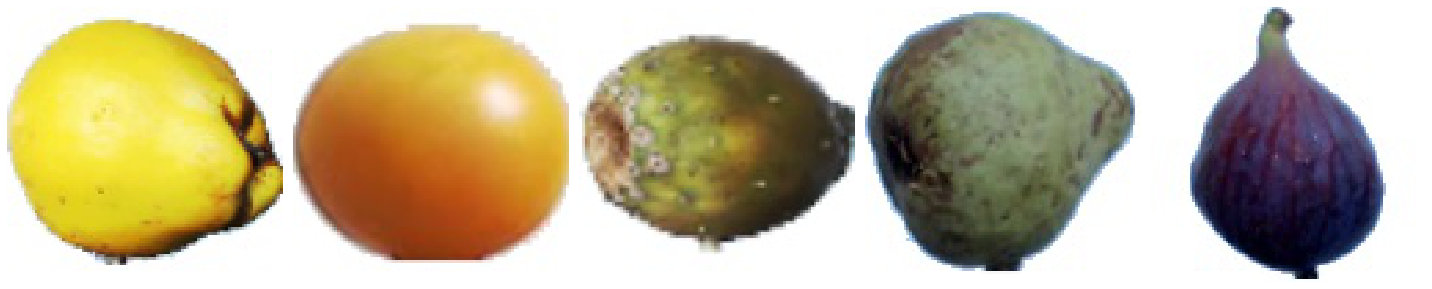

In [18]:
plotImages(sample_training_images[:5])

# Baseline Handmade Model

## Compile and Train

In [41]:
model_baseline = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [42]:
model_baseline.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy', 'AUC'])

In [43]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [44]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=67692 // batch_size,
                             epochs=epochs,
                             validation_data=val_data_gen,
                             validation_steps=22688 // batch_size,
                             callbacks=[tensorboard])

Epoch 1/15
528/528 [==============================] - 33s 63ms/step - loss: 0.4451 - categorical_accuracy: 0.8929 - auc: 0.9951 - val_loss: 0.2267 - val_categorical_accuracy: 0.9363 - val_auc: 0.9945
Epoch 2/15
528/528 [==============================] - 33s 63ms/step - loss: 0.0185 - categorical_accuracy: 0.9950 - auc: 0.9998 - val_loss: 0.1178 - val_categorical_accuracy: 0.9661 - val_auc: 0.9979
Epoch 3/15
528/528 [==============================] - 33s 62ms/step - loss: 0.0178 - categorical_accuracy: 0.9958 - auc: 0.9997 - val_loss: 0.2834 - val_categorical_accuracy: 0.9343 - val_auc: 0.9939
Epoch 4/15
528/528 [==============================] - 33s 62ms/step - loss: 0.0111 - categorical_accuracy: 0.9969 - auc: 0.9999 - val_loss: 0.2316 - val_categorical_accuracy: 0.9407 - val_auc: 0.9950
Epoch 5/15
528/528 [==============================] - 33s 62ms/step - loss: 0.0152 - categorical_accuracy: 0.9959 - auc: 0.9998 - val_loss: 0.3171 - val_categorical_accuracy: 0.9312 - val_auc: 0.9887


In [45]:
model_baseline.save('baseline_model_NOTHING_more.hdf5')

where_to_save = 'baseline_model_NOTHING_more_weights'
model_baseline.save_weights(filepath=where_to_save,
                            overwrite=True)

In [56]:
# Clear VRAM
K.clear_session()

## Learning Curve

In [46]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_auc'])

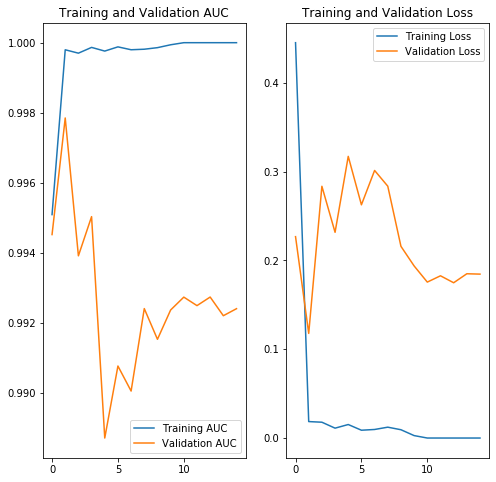

In [47]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

In [19]:
model_baseline.load_weights('Handmade_model_baseline_weights')

In [48]:
y_pred = model_baseline.predict(test_data_gen,
                                batch_size=batch_size,
                                    steps=num_test/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=1)

178/177 [==============================] - 8s 44ms/step


In [49]:
y_true = test_data_gen.classes

In [50]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.09      0.10       164
           1       0.14      0.14      0.14       148
           2       0.17      0.20      0.19       160
           3       0.21      0.22      0.21       164
           4       0.18      0.20      0.19       161
           5       0.22      0.22      0.22       164
           6       0.14      0.16      0.15       152
           7       0.17      0.15      0.16       164
           8       0.21      0.22      0.21       164
           9       0.14      0.11      0.12       144
          10       0.23      0.23      0.23       166
          11       0.23      0.22      0.23       164
          12       0.46      0.42      0.44       219
          13       0.22      0.22      0.22       164
          14       0.10      0.10      0.10       143
          15       0.23      0.23      0.23       166
          16       0.28      0.23      0.25       166
          17       0.18    

### Inspection

In [51]:
y_pred[:100]

array([ 8, 70,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  0,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

# Approachs to Improve Performance

Even out simplest model gets a quiet good result, but I want to test if is improved by several common techniques, which are:
* Data augmentation
* Dropout.

## Data Augmentation

In [52]:
train_generator = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               rotation_range=45,
                                    validation_split=0.2)

In [53]:
# Train set
train_data_gen = train_generator.flow_from_directory(directory=where_train, 
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         class_mode='categorical',
                                         shuffle=True,
                                         batch_size=batch_size,
                                         subset='training')

val_data_gen = train_generator.flow_from_directory(directory=where_train,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode='categorical',
                                        shuffle=True,
                                        batch_size=batch_size,
                                        subset='validation')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


In [54]:
sample_training_images, _ = next(train_data_gen)

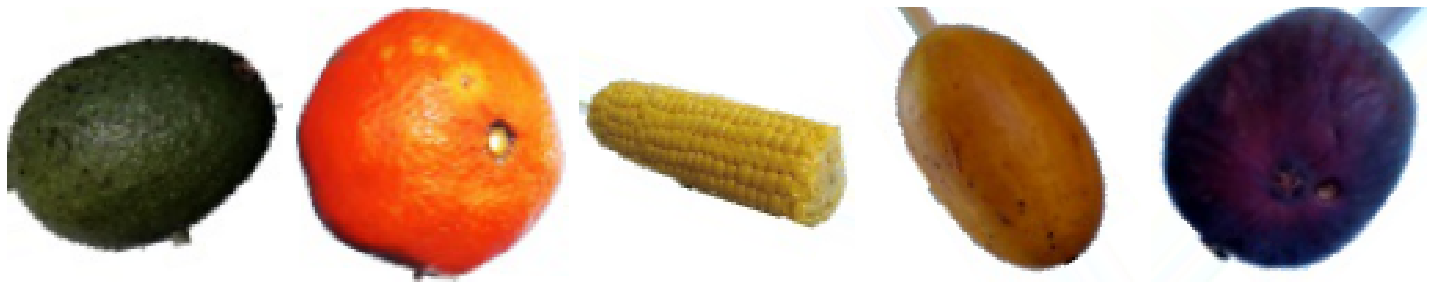

In [55]:
plotImages(sample_training_images[:5])

We only apply image augmentation on the training data, not on the test dataset.  
Because the test set should be remained as its origin.

## Dropout

***What is Dropout***

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in this tutorial

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Complexitify

# Improved Model - Ver 1

## Compile and Train

In [57]:
model_with_dropout = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

model_with_dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0

In [58]:
model_with_dropout.compile(optimizer='adam',
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['categorical_accuracy', 'AUC'])

In [59]:
NAME = 'Handmade_model_Augmentation_Dropout_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [60]:
%%time
history = model_with_dropout.fit(train_data_gen,
                                 steps_per_epoch=67692 // batch_size,
                                 epochs=epochs,
                                 validation_data=val_data_gen,
                                 validation_steps=22688 // batch_size,
                                 callbacks=[tensorboard])

Epoch 1/15
528/528 [==============================] - 166s 315ms/step - loss: 0.9405 - categorical_accuracy: 0.7511 - auc: 0.9874 - val_loss: 0.6183 - val_categorical_accuracy: 0.8042 - val_auc: 0.9906
Epoch 2/15
528/528 [==============================] - 161s 306ms/step - loss: 0.1071 - categorical_accuracy: 0.9653 - auc: 0.9992 - val_loss: 0.2653 - val_categorical_accuracy: 0.9199 - val_auc: 0.9959
Epoch 3/15
528/528 [==============================] - 161s 305ms/step - loss: 0.0627 - categorical_accuracy: 0.9806 - auc: 0.9994 - val_loss: 0.2393 - val_categorical_accuracy: 0.9290 - val_auc: 0.9956
Epoch 4/15
528/528 [==============================] - 159s 301ms/step - loss: 0.0417 - categorical_accuracy: 0.9866 - auc: 0.9996 - val_loss: 0.2484 - val_categorical_accuracy: 0.9337 - val_auc: 0.9935
Epoch 5/15
528/528 [==============================] - 158s 299ms/step - loss: 0.0436 - categorical_accuracy: 0.9863 - auc: 0.9995 - val_loss: 0.1630 - val_categorical_accuracy: 0.9517 - val_au

In [61]:
model_with_dropout.save_weights('model_with_dropout',
                                overwrite=False)

In [51]:
# Clear VRAM
K.clear_session()

## Learning Curve

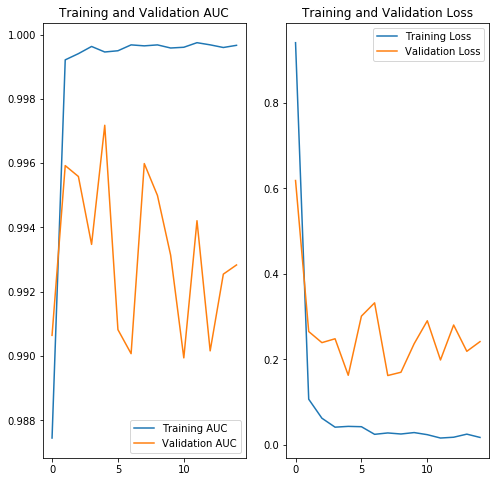

In [62]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

We will only use 1500 out of the entire test set, as time cost for all of them are so high.

In [34]:
model_with_dropout.load_weights('Handmade_model_Augmentation_Dropout_weights')

In [76]:
%%time
y_pred = model_with_dropout.predict(test_data_gen,
                                    steps=22688/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=1)

178/177 [==============================] - 8s 44ms/step
CPU times: user 10.4 s, sys: 366 ms, total: 10.8 s
Wall time: 7.94 s


## Inspect y_pred

In [79]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [51]:
type(y_pred)

numpy.ndarray

In [80]:
a, b = np.unique(y_pred, return_counts=True)
print(b)

[134 129 139 225 213 201 123 182 178 145 166 139 219 164 164 167 115 184
 177 160 154 137 164 208 145 244 164 246 186 164 164 164 156 111 154  73
 124 131 156 166 136 234  81 166 328 165 166 166 164 158 165 164 166 157
 166 166 156 158 177 200 166 166 167 166 166 142 102 141 211 187 168 139
 218 182 163 154 231 160 177 173 164 250 145  71 269 155 238 102 182 222
 309 181 166 172 234 222 222 164 175 166 163 166 151 142 283 201 153 156
 151 144 151 166 164 166 164 162 164 202 166 166 246 251 246 160 193 228
 127 153 134 250 157]


In [67]:
y_pred.shape

(22718,)

In [66]:
y_pred[0:20]

array([125, 117,  29, 128, 111, 121, 118,  35, 117,   0,  86, 120,  81,
        32,  91, 130,  72, 117,  55,  58])

## Class Report

In [81]:
y_true = test_data_gen.classes

In [82]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219
          13       0.00      0.00      0.00       164
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       166
          16       0.00      0.00      0.00       166
          17       0.00    

# Improved Model - Ver 2

## Compile and Train

In [32]:
model_with_dropout = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

model_with_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)       

In [33]:
model_with_dropout.compile(optimizer='adam',
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=['categorical_accuracy', 'AUC'])

In [40]:
NAME = 'Handmade_model_Augmentation_Dropout_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [41]:
%%time
history = model_with_dropout.fit(train_data_gen,
                                 steps_per_epoch=67692 // batch_size,
                                 epochs=epochs,
                                 validation_data=val_data_gen,
                                 validation_steps=22688 // batch_size,
                                 callbacks=[tensorboard])

Epoch 1/15
528/528 [==============================] - 132s 250ms/step - loss: 0.8467 - categorical_accuracy: 0.7749 - auc: 0.9899 - val_loss: 0.3945 - val_categorical_accuracy: 0.8863 - val_auc: 0.9930
Epoch 2/15
528/528 [==============================] - 130s 247ms/step - loss: 0.1065 - categorical_accuracy: 0.9651 - auc: 0.9992 - val_loss: 0.2698 - val_categorical_accuracy: 0.9235 - val_auc: 0.9954
Epoch 3/15
528/528 [==============================] - 130s 246ms/step - loss: 0.0626 - categorical_accuracy: 0.9804 - auc: 0.9994 - val_loss: 0.2999 - val_categorical_accuracy: 0.9250 - val_auc: 0.9939
Epoch 4/15
528/528 [==============================] - 130s 246ms/step - loss: 0.0460 - categorical_accuracy: 0.9852 - auc: 0.9996 - val_loss: 0.2574 - val_categorical_accuracy: 0.9497 - val_auc: 0.9932
Epoch 5/15
528/528 [==============================] - 131s 248ms/step - loss: 0.0453 - categorical_accuracy: 0.9857 - auc: 0.9995 - val_loss: 0.1952 - val_categorical_accuracy: 0.9615 - val_au

In [1]:
model_with_dropout.save_weights('model_with_dropout',
                                overwrite=False)

NameError: name 'model_with_dropout' is not defined

In [51]:
# Clear VRAM
K.clear_session()

## Learning Curve

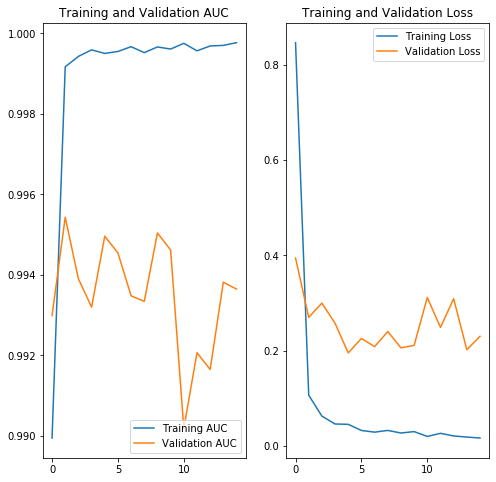

In [46]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

We will only use 1500 out of the entire test set, as time cost for all of them are so high.

In [34]:
model_with_dropout.load_weights('Handmade_model_Augmentation_Dropout_weights')

In [35]:
%%time
y_pred = model_with_dropout.predict(val_data_gen,
                                    steps=22688/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=1)

178/177 [==============================] - 8s 43ms/step
CPU times: user 10.2 s, sys: 424 ms, total: 10.6 s
Wall time: 7.83 s


## Inspect y_pred

In [40]:
print(y_pred)

[2 2 2 ... 2 2 2]


In [51]:
type(y_pred)

numpy.ndarray

In [57]:
a, b = np.unique(y_pred, return_counts=True)
print(b)

[236 117 163 117 242 167 176 209  41 210 167 164 219 164 143 147 140 209
 164  94 154 182 164 163 175 305 164 246 246 164 164 164 167 163 159  64
 112 130 156 175 132 257  59 206 328 164 166 166 164 158 166 164 166 157
 166 166 156 157 144 174 153 166 166 166 166 142 102 238 246 186  93 160
 218 172 169 146 184 160 164 175 164 246 162  53 158 156 317 134 150 225
 284 164 166 174 234 222 222 164 158 169 163 166 151 142 307 197 153 158
 121 119 155 112 188 166 164 153 164 227 190 166 246 225 246 160 164 228
 127 153 142 259 160]


In [41]:
y_pred.shape

(22688,)

In [60]:
y_pred[0:20]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Class Report

In [38]:
y_true = val_data_gen.labels

In [39]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219
          13       0.00      0.00      0.00       164
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       166
          16       0.00      0.00      0.00       166
          17       0.00    

# Evaluate

In [39]:
# Gini score to evaluate performances of models gini_score= 2*auc -1
def gini_score(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini_coef = 2 * roc_auc - 1
    print('Gini score: %5.4f' %(gini_coef))
    
    return gini_coef

In [41]:
gini_score(y_true, y_pred)

ValueError: multiclass format is not supported

# Analysis and Compare Models